<a href="https://colab.research.google.com/github/manchikantisowmya/ML_HARTH/blob/main/DATA245_harth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition, manifold, preprocessing, model_selection
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
sns.set_theme()

### Parameters

In [ ]:
test_size = 0.2
train_size = 1 - test_size
random_seed = 42

class_code_to_class_name = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)',
}

class_code_to_id = {}
id_to_class_code = {}
id_to_class_name = {}
for i, code in enumerate(class_code_to_class_name.keys()):
    class_code_to_id[code] = i
    id_to_class_code[i] = code
    id_to_class_name[i] = class_code_to_class_name[code]

num_classes = len(class_code_to_id)

print(id_to_class_name)

{0: 'walking', 1: 'running', 2: 'shuffling', 3: 'stairs (ascending)', 4: 'stairs (descending)', 5: 'standing', 6: 'sitting', 7: 'lying', 8: 'cycling (sit)', 9: 'cycling (stand)', 10: 'cycling (sit, inactive)', 11: 'cycling (stand, inactive)'}


In [ ]:
def remap_labels(y):
    '''Converts class codes into consecutive ids.'''
    remap_y = y.copy()
    for class_code, class_id in class_code_to_id.items():
        remap_y[y == class_code] = class_id
    return remap_y

X = np.load('/content/drive/Shareddrives/MSDA_245/project_group6/features.npy')
y_orig = np.load('/content/drive/Shareddrives/MSDA_245/project_group6/labels.npy')
y = remap_labels(y_orig)
print(X.shape)
print(y)
print(f'Number of classes: {num_classes}')
print(f'Number of features: {X.shape[1]}')
print(f'Number of samples: {X.shape[0]}')



(25853, 88)
[2 5 5 ... 1 1 1]
Number of classes: 12
Number of features: 88
Number of samples: 25853


In [ ]:
print(f"Missing values in X: {np.isnan(X).sum()}")
print(f"Missing values in y: {np.isnan(y).sum()}")

Missing values in X: 0
Missing values in y: 0


array([11292.10291257, 21813.14083028, 37840.73230832, ...,
       48579.38660544, 27292.22762001, 29243.93601571])

In [63]:
def plot_class_distribution(y, ax, title):
    labels, counts = np.unique(y, return_counts=True)
    counts = counts / counts.sum()

    ax.bar(labels, counts, align='center')
    ax.set_xticks(list(id_to_class_name.keys()), list(id_to_class_name.values()), rotation=45, ha='right')
    ax.set_title(title)

### Create test set

Number of train samples: 20682
Number of test samples: 5171


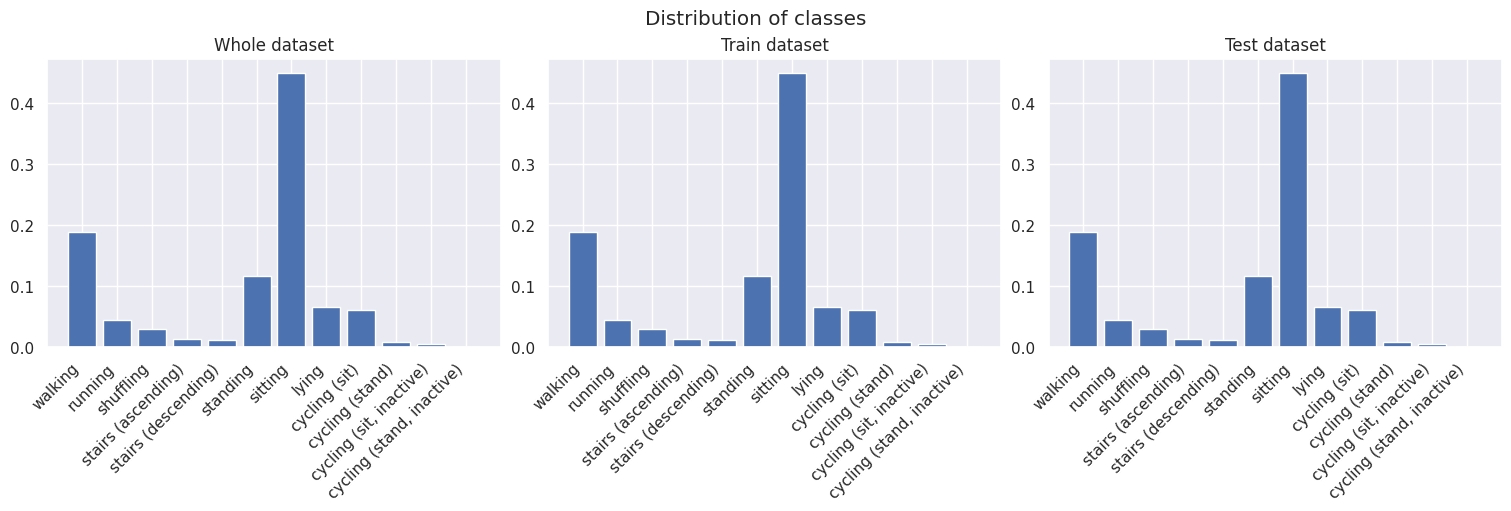

In [64]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    stratify=y,
                                                                    test_size=test_size,
                                                                    random_state=random_seed)
print(f'Number of train samples: {X_train.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

fig = plt.figure(figsize=(15, 5), constrained_layout=True)
gs = fig.add_gridspec(1,3)

ax = fig.add_subplot(gs[0, 0])
plot_class_distribution(y, ax, title='Whole dataset')

ax = fig.add_subplot(gs[0, 1])
plot_class_distribution(y_train, ax, title='Train dataset')

ax = fig.add_subplot(gs[0,2])
plot_class_distribution(y_test, ax, title='Test dataset')

plt.suptitle('Distribution of classes')
plt.show()
plt.close()

### PCA

In [ ]:
def plot_pca(X_pca, y, n_components):
    X_list = [X_pca[:, i] for i in range(n_components)]

    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()
    ax.scatter(*X_list, c=y)
    ax.set_title(f'Distribution of data using PCA with {n_components = }')
    plt.show()
    plt.close()

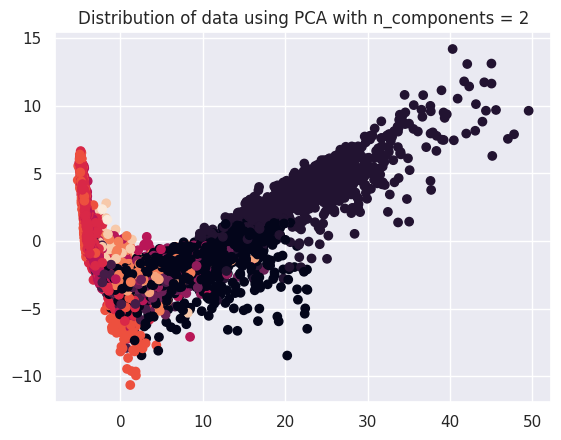

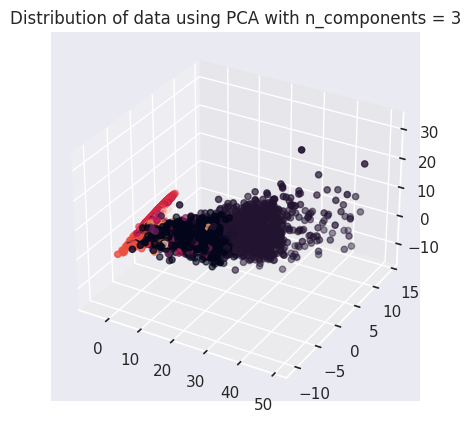

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

pca = decomposition.PCA()
pca.fit(X_train_norm)
X_train_norm_pca = pca.transform(X_train_norm)
X_test_norm_pca = pca.transform(X_test_norm)

plot_pca(X_train_norm_pca, y_train, n_components=2)
plot_pca(X_train_norm_pca, y_train, n_components=3)

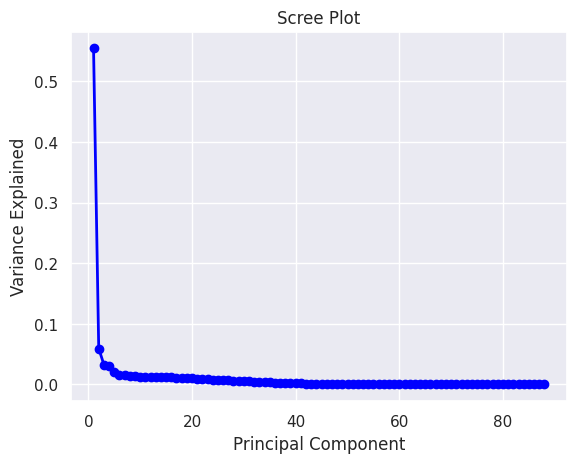

In [ ]:
x_ticks = np.arange(pca.n_components_) + 1
plt.plot(x_ticks, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Nomalize Features

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer

# Normalize the features.
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Modeling


In [ ]:
def compute_model_metrics(model, X, y_true):
    y_pred = model.predict(X)

    print("Confusion Matrix")
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix, cmap="crest",  annot=True, fmt="d", linewidths=.1)
    xticks = [i + 0.5 for i in id_to_class_name.keys()]
    ax.set_xticks(
        xticks, list(id_to_class_name.values()), rotation=45, ha='right'
    )
    ax.set_yticks(
        xticks, list(id_to_class_name.values()), rotation=0, va='top'
    )
    plt.show()

    report = metrics.classification_report(
        y_true, y_pred, target_names=list(id_to_class_name.values()), digits=4
    )
    print(report)
    test_acc = metrics.accuracy_score(y_true, y_pred)
    print(f'Accuracy: {test_acc:.4f}')

    test_precision = metrics.precision_score(y_true, y_pred, average='micro')
    print(f'Micro Precision: {test_precision:.4f}')

    test_recall = metrics.recall_score(y_true, y_pred, average='micro')
    print(f'Micro Recall/TPR: {test_recall:.4f}')

    test_f1 = metrics.f1_score(y_true, y_pred, average='micro')
    print(f'Micro f1-score: {test_f1:.4f}')

## SVM

## KNN

## Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
parameters = [
    {'penalty': ['l2'], 'multi_class': ['multinomial'], 'solver':['lbfgs']},
    {'penalty': ['l2'], 'multi_class': ['ovr'], 'solver':['liblinear']},
]

grid_search = GridSearchCV(
    LogisticRegression(max_iter=100), parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs=2, return_train_score=True
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

Best training accuracy with 5-fold cross validation: 0.938932413484201
Best parameters: 
{'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Fit using the best model.

lr_clf = LogisticRegression(penalty="l2", multi_class='multinomial', C=10, max_iter=100)
lr_clf.fit(X_train_norm, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, multi_class='multinomial')

Confusion Matrix


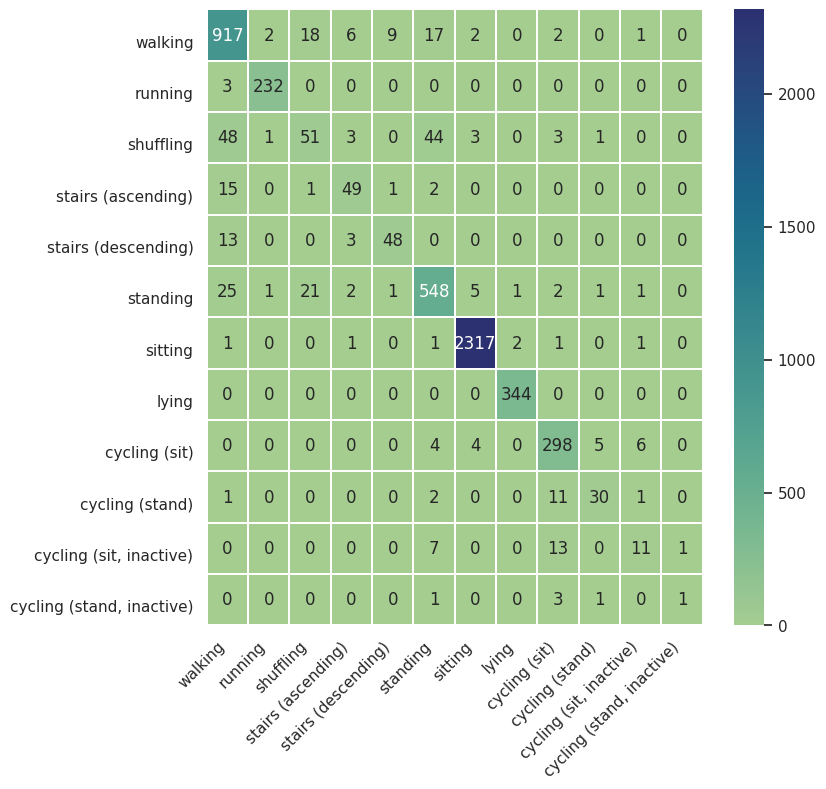

                           precision    recall  f1-score   support

                  walking     0.8964    0.9415    0.9184       974
                  running     0.9831    0.9872    0.9851       235
                shuffling     0.5604    0.3312    0.4163       154
       stairs (ascending)     0.7656    0.7206    0.7424        68
      stairs (descending)     0.8136    0.7500    0.7805        64
                 standing     0.8754    0.9013    0.8882       608
                  sitting     0.9940    0.9970    0.9955      2324
                    lying     0.9914    1.0000    0.9957       344
            cycling (sit)     0.8949    0.9401    0.9169       317
          cycling (stand)     0.7895    0.6667    0.7229        45
  cycling (sit, inactive)     0.5238    0.3438    0.4151        32
cycling (stand, inactive)     0.5000    0.1667    0.2500         6

                 accuracy                         0.9371      5171
                macro avg     0.7990    0.7288    0.7522    

In [ ]:
compute_model_metrics(lr_clf, X_test_norm, y_test)

## XGBoost

# Performance with Dimensionality Reduction

## PCA

In [ ]:
def test_with_pca_components(model, X_train, y_train, X_test, y_test, components_list):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X)
    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)

    pca = decomposition.PCA()
    pca.fit(X_train_norm)
    X_train_norm_pca = pca.transform(X_train_norm)
    X_test_norm_pca = pca.transform(X_test_norm)

    accuracies = []
    for n in components_list:
        model.fit(X_train_norm_pca[:, :n], y_train)
        y_test_pred = model.predict(X_test_norm_pca[:, :n])
        acc = metrics.accuracy_score(y_test, y_test_pred)
        accuracies.append(acc)
        print(f'Testing for {n = }, {acc = }')

    return accuracies

In [ ]:
models = {
    'svm': SVC(C=100, gamma=0.001, kernel='rbf'),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'logistic_regression': LogisticRegression(
        penalty="l2",
        multi_class='multinomial',
        C=10,
        max_iter=100
    ),
    'xgboost': XGBClassifier(
        num_class=num_classes,
        objective= 'multi:softmax',
        learning_rate=0.1,
        n_estimators=50,
        max_depth=8,
        nthread=4,
        seed=42
    )
}

components = [1, 2, 4, 10, 20, 40, 60, X_train.shape[1]]

accuracies = {}
for name, model in models.items():
    print(f'Running {name}')
    accuracies[name] = test_with_pca_components(model, X_train, y_train, X_test, y_test, components)

Running svm
Testing for n = 1, acc = 0.6824598723651132
Testing for n = 2, acc = 0.6925159543608587
Testing for n = 4, acc = 0.7783794237091471
Testing for n = 10, acc = 0.8878360085089925
Testing for n = 20, acc = 0.9218719783407465
Testing for n = 40, acc = 0.9390833494488493
Testing for n = 60, acc = 0.9435312318700445
Testing for n = 88, acc = 0.9437246180622704
Running knn
Testing for n = 1, acc = 0.6484239025333591
Testing for n = 2, acc = 0.6977373815509572
Testing for n = 4, acc = 0.7921098433571843
Testing for n = 10, acc = 0.8953780700058016
Testing for n = 20, acc = 0.9036936762715142
Testing for n = 40, acc = 0.9222587507251983
Testing for n = 60, acc = 0.9239992264552311
Testing for n = 88, acc = 0.9249661574163605
Running logistic_regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 1, acc = 0.67182363179269


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 2, acc = 0.6845871204795978


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 4, acc = 0.7447302262618449


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 10, acc = 0.8512860181783021


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 20, acc = 0.8988590214658674


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 40, acc = 0.9286404950686521


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 60, acc = 0.9392767356410753


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing for n = 88, acc = 0.9386965770643976
Running xgboost
Testing for n = 1, acc = 0.6824598723651132
Testing for n = 2, acc = 0.7250048346548057
Testing for n = 4, acc = 0.8048733320440921
Testing for n = 10, acc = 0.9069812415393541
Testing for n = 20, acc = 0.9174240959195513
Testing for n = 40, acc = 0.9299941984142333
Testing for n = 60, acc = 0.9338619222587508
Testing for n = 88, acc = 0.9327016051053955


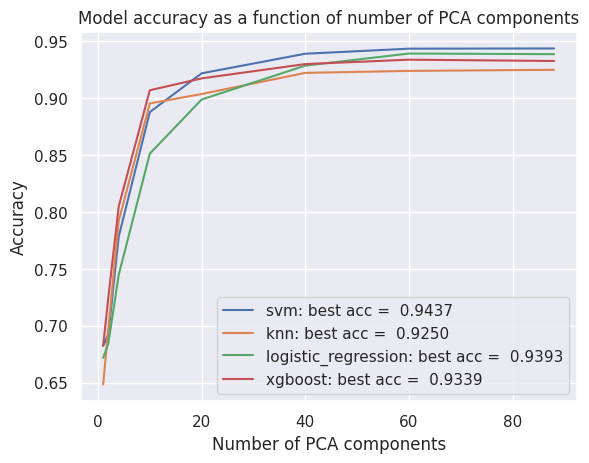

In [ ]:
plt.figure()
for name, acc in accuracies.items():
    max_acc = max(acc)
    plt.plot(components, acc, label=f'{name}: best acc = {max_acc: .4f}')

plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model accuracy as a function of number of PCA components')
plt.show()

## t-SNE

Running TSNE


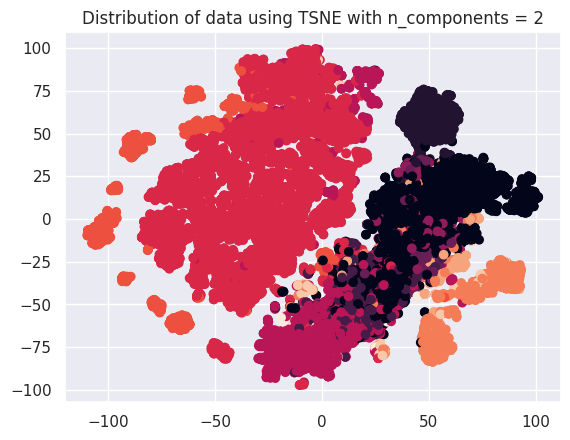

Running TSNE


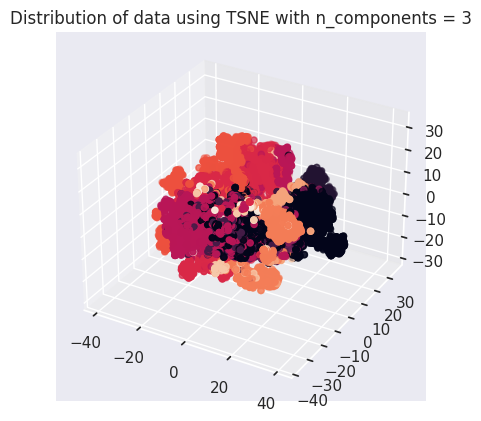

In [ ]:
def plot_tsne(X, y, n_components):
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)

    print('Running TSNE')
    tsne = manifold.TSNE(
        n_components=n_components,
        init='pca',
        learning_rate='auto',
        n_jobs=4,
        random_state=0,
    )
    X_tsne = tsne.fit_transform(X)
    X_list = [X_tsne[:, i] for i in range(n_components)]

    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()
    ax.scatter(*X_list, c=y)
    ax.set_title(f'Distribution of data using TSNE with {n_components = }')
    plt.show()
    plt.close()

plot_tsne(X_train, y_train, n_components=2)
plot_tsne(X_train, y_train, n_components=3)